In [1]:
%env CC=gcc-11
%env CXX=g++-11

env: CC=gcc-11
env: CXX=g++-11


In [2]:
DATASET_NAME="2d-gmm-pick_miss_cup"

##### Normal data

In [3]:
import pandas

DATA = pandas.read_csv('../../../robot-data/new_data/normal/merged_normal_pick.csv')
DATA

,Counter(/arm_trajectory_controller/follow_joint_trajectory/status),/arm_trajectory_controller/follow_joint_trajectory/status My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Var_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Counter(/arm_trajectory_controller/state),/arm_trajectory_controller/state My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/state),Counter(/battery),/battery My_Traffic(Bytes),Counter(/detected_objects),...,shoulder2_joint position,torso_joint position,left_wheel_joint effort,right_finger_joint effort,right_wheel_joint effort,rotation1_joint effort,torso_joint effort,wrist_joint effort,head_tilt_joint velocity,left_wheel_joint velocity
0,4,284,0.264902,1.264027e-02,12,6456,0.071533,0,0,0,...,2.183829,0.301,0.0,-0.02690,0.0,-0.064453,92.853043,0.032227,0.0,0.0
1,5,355,0.200013,4.539819e-05,14,7532,0.069651,1,93,0,...,2.183829,0.301,0.0,-0.02421,0.0,-0.080566,82.853053,0.008057,0.0,0.0
2,5,355,0.201024,3.146104e-06,12,6456,0.087292,0,0,0,...,2.183829,0.298,0.0,-0.02421,0.0,0.000000,88.853035,0.052368,0.0,0.0
3,5,355,0.200395,2.509922e-06,11,5918,0.086181,1,93,0,...,2.183829,0.303,0.0,-0.02421,0.0,0.000000,104.853008,0.032227,0.0,0.0
4,5,355,0.200118,1.580059e-06,13,6994,0.081231,0,0,1,...,2.183829,0.299,0.0,-0.02690,0.0,-0.112793,90.853009,0.008057,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,5,610,0.200005,3.723324e-07,15,8070,0.067330,0,0,1,...,2.183880,0.277,0.0,0.46268,0.0,0.000000,-85.098008,0.056396,0.0,0.0
1672,5,610,0.200002,2.663688e-08,15,8070,0.066322,1,93,2,...,2.183880,0.272,0.0,0.45999,0.0,0.000000,-78.543533,0.060425,0.0,0.0
1673,5,610,0.199537,8.526598e-07,15,8070,0.068983,0,0,1,...,2.183880,0.268,0.0,0.45999,0.0,0.048340,-75.750176,0.060425,0.0,0.0
1674,5,610,0.198214,1.329264e-05,15,8070,0.066772,1,93,1,...,2.183880,0.263,0.0,0.45999,0.0,0.000000,-72.689521,0.060425,0.0,0.0


##### Anomaly data

In [4]:
ANOMALY_DATA = pandas.read_csv('../../../robot-data/new_data/test/merged_pick_miss_cup.csv')
ANOMALY_DATA

,Counter(/arm_trajectory_controller/follow_joint_trajectory/status),/arm_trajectory_controller/follow_joint_trajectory/status My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Var_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Counter(/arm_trajectory_controller/state),/arm_trajectory_controller/state My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/state),Counter(/battery),/battery My_Traffic(Bytes),Counter(/detected_objects),...,left_wheel_joint effort,right_wheel_joint effort,rotation1_joint effort,torso_joint effort,wrist_joint effort,head_tilt_joint velocity,left_wheel_joint velocity,right_wheel_joint velocity,shoulder1_joint velocity,shoulder2_joint velocity
0,6,120,0.190663,1.291337e-02,12,6456,0.063092,0,0,0,...,0.0,0.0,0.000000,-7.569872,0.000000,0.0,0.0,0.0,0.000000,0.0
1,5,100,0.199080,3.438309e-06,15,8070,0.065023,0,0,0,...,0.0,0.0,0.000000,-1.429256,0.008057,0.0,0.0,0.0,0.000000,0.0
2,5,100,0.200019,1.036475e-05,16,8608,0.064299,1,93,0,...,0.0,0.0,0.000000,-7.379467,0.000000,0.0,0.0,0.0,0.000000,0.0
3,5,100,0.199980,1.747321e-05,14,7532,0.070981,0,0,0,...,0.0,0.0,0.000000,-1.260519,0.008057,0.0,0.0,0.0,0.000000,0.0
4,5,100,0.200011,4.932453e-08,15,8070,0.064694,1,93,0,...,0.0,0.0,0.000000,-3.198487,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,5,360,0.199993,1.427605e-08,15,8070,0.068399,0,0,1,...,0.0,0.0,-0.064453,-81.999998,0.056396,0.0,0.0,0.0,0.000000,0.0
1686,5,360,0.199986,9.456916e-08,14,7532,0.069274,1,93,0,...,0.0,0.0,-0.128906,-87.999980,0.056396,0.0,0.0,0.0,0.000000,0.0
1687,5,360,0.199958,1.688842e-08,14,7532,0.074080,0,0,0,...,0.0,0.0,-0.064453,-82.051771,0.056396,0.0,0.0,0.0,0.000000,0.0
1688,5,360,0.199994,1.212901e-06,14,7532,0.067554,1,93,1,...,0.0,0.0,-0.048340,-91.781406,0.056396,0.0,0.0,0.0,0.000209,0.0


In [5]:
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm
import numpy as np
import heapq
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
from sklearn.decomposition import PCA
import datetime
from IPython.display import Image
import math
import pickle

In [6]:
scalers = {}

def normalize_data(original_data):
    """
    This function used for normalizing data, with MinMaxScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = original_data
    for i in original_data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def std_normalize_data(data):
    """
    This function used for normalizing data, with StandardScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = data
    for i in data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def unnormalize_data(columns, reconstructed_data):
    """
    This function is normalization inverse function.
    :param columns: orinal columns names, used for taking correct scaler that was saved while normalization
    :param reconstructed_data: normalized data
    :return: unnormalized data 
    """
    restored_data = []
    for (i, name) in enumerate(columns):
        restored_data.append(np.array(scalers['scaler_' + name].inverse_transform(reconstructed_data[:,i].reshape(-1, 1))).flatten())
    return np.array(restored_data)

def draw_from_GMM(mus, sigmas, thetas, numOfDraws = 1):
    """
    This function draws samples based on mu, sigma and theta of Gaussian Mixture Model
    :param mus: list of mus
    :param sigmas: list of sigmas
    :param thetas: list of thetas
    :param numOfDraws: number of draws from distribution
    :return: list of samples and list of lists of samples
    """
    gmm_res = []
    gaussians = []
    for j in range(len(thetas[0])):
        gaussians.append([])
    for i in tqdm(range(len(mus))):
        mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
        samples = np.random.normal(mus[i,mixture_idx], sigmas[i,mixture_idx], size=numOfDraws)
        sample_index = np.random.choice(len(samples), size=1, replace=True)[0]
        gmm_res.append(samples[sample_index]) 
        gaussians[mixture_idx].append(samples[sample_index])
    return gmm_res, gaussians

def calc_lppd(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in tqdm(range(len(y))):
        ppd_res = 0
        for i in range(len(mus)):
            mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
            ppd_res += norm.pdf(y[n], mus[i, mixture_idx], sigmas[i, mixture_idx])
        lppds.append(math.log(ppd_res/len(mus))) 
        
    return lppds, np.sum(lppds)

def calc_lppd_vec(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in range(len(y)):
        ppd_res = 0
        pdf = norm.pdf(y[n], mus, sigmas)
        ppd_res = np.sum(np.multiply(thetas, pdf))
        lppds.append(math.log(ppd_res/len(mus)))
    return lppds, np.sum(lppds)

def calc_lppd_vec_sliding_window(mu, sigma, theta, y, window_size=5):
    windows = np.lib.stride_tricks.sliding_window_view(y, window_size)
    wlppd = []
    for w in windows:
        lppds, lppd = calc_lppd_vec(mu, sigma, theta, w)
        wlppd.append(np.average(lppds))
    return wlppd, np.sum(wlppd)


def sliding_windows(data, seq_length):
    """
    Sliding window transformation for the data
    :param data: original data
    :param seq_length: window size
    :return: two arrays of x and y
    """
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)



#### Autoencoder for dimention reduction

In [23]:
import keras
from keras.layers import Input, Dense
from keras.models import Model


def train_autoencoder(data, layer_size=128, seq_len=100, reduced_features=2, epochs=500):
    encoder = None
    if os.path.isdir('./stan/'+ DATASET_NAME + '_' + str(reduced_features) + '_encoder_model.ml'):
        encoder = keras.models.load_model('./stan/'+ DATASET_NAME + '_' + str(reduced_features) + '_encoder_model.ml')
    else:
        input_data = Input(shape=(data.shape[1],))
        encoded1 = Dense(layer_size, activation='relu')(input_data)
        encoded2 = Dense(layer_size/2, activation='relu')(encoded1)
        encoded3 = Dense(reduced_features, activation='relu')(encoded2)
        decoded1 = Dense(layer_size/2, activation='relu')(encoded3)
        decoded2 = Dense(layer_size, activation=None)(decoded1)
        decoded3 = Dense(data.shape[1], activation=None)(decoded2)
        autoencoder = Model(input_data, decoded3)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        autoencoder.summary()
        autoencoder.fit(data, data,
                        epochs=epochs,
                        batch_size=16,
                        shuffle=True)
        encoder = Model(input_data, encoded3)
        encoder.save('./stan/'+ DATASET_NAME + '_' + str(reduced_features) + '_encoder_model.ml')
    return encoder

##### Choosing common columns

While looking on the data we saw that there are small difference in the columns of anomaly and normal data, so we tried to find common columns.

In [8]:
def common_columns(data, anomaly_data):
    norm_data, columns = normalize_data(data.copy()).values, list(data.columns.values)

    columns = data.columns
    anomaly_columns = anomaly_data.columns
    common_columns = np.intersect1d(columns, anomaly_columns)
    common_columns = [x for _, x in sorted(zip(columns, common_columns), key=lambda pair: pair[0])]
    anomaly_norm_data = normalize_data(anomaly_data.copy())[common_columns].values
    print("Common columns:", anomaly_norm_data.shape)
    norm_data = normalize_data(data[common_columns].copy())
    print('Original dataset shape:', norm_data.shape)
    return norm_data, anomaly_norm_data, columns

In [9]:
normalized_data, anomaly_normalized_data, columns = common_columns(DATA, ANOMALY_DATA)

Common columns: (1690, 249)
Original dataset shape: (1676, 249)


#### Train autoencoder 

In [24]:
encoder = train_autoencoder(normalized_data, normalized_data.shape[1]/2, epochs=1000, reduced_features=3)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 249)]             0         
_________________________________________________________________
dense (Dense)                (None, 124)               31000     
_________________________________________________________________
dense_1 (Dense)              (None, 62)                7750      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 189       
_________________________________________________________________
dense_3 (Dense)              (None, 62)                248       
_________________________________________________________________
dense_4 (Dense)              (None, 124)               7812      
_________________________________________________________________
dense_5 (Dense)              (None, 249)               31125 

105/105 [==============================] - 0s 1ms/step - loss: 0.2689
Epoch 84/1000
105/105 [==============================] - 0s 895us/step - loss: 0.2639
Epoch 85/1000
105/105 [==============================] - 0s 936us/step - loss: 0.2580
Epoch 86/1000
105/105 [==============================] - 0s 993us/step - loss: 0.2534
Epoch 87/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2497
Epoch 88/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2428
Epoch 89/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2391
Epoch 90/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.2319
Epoch 91/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.2302
Epoch 92/1000
105/105 [==============================] - 0s 953us/step - loss: 0.2257
Epoch 93/1000
105/105 [==============================] - 0s 926us/step - loss: 0.2216
Epoch 94/1000
105/105 [==============================] - 0s 871us/step - loss: 0

105/105 [==============================] - 0s 1ms/step - loss: 0.1451
Epoch 180/1000
105/105 [==============================] - 0s 934us/step - loss: 0.1426
Epoch 181/1000
105/105 [==============================] - 0s 949us/step - loss: 0.1447
Epoch 182/1000
105/105 [==============================] - 0s 950us/step - loss: 0.1469
Epoch 183/1000
105/105 [==============================] - 0s 905us/step - loss: 0.1446
Epoch 184/1000
105/105 [==============================] - 0s 869us/step - loss: 0.1426
Epoch 185/1000
105/105 [==============================] - 0s 960us/step - loss: 0.1442
Epoch 186/1000
105/105 [==============================] - 0s 919us/step - loss: 0.1462
Epoch 187/1000
105/105 [==============================] - 0s 995us/step - loss: 0.1406
Epoch 188/1000
105/105 [==============================] - 0s 865us/step - loss: 0.1441
Epoch 189/1000
105/105 [==============================] - 0s 911us/step - loss: 0.1461
Epoch 190/1000
105/105 [==============================] - 0s

105/105 [==============================] - 0s 1ms/step - loss: 0.1416
Epoch 275/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1383
Epoch 276/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1414
Epoch 277/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1387
Epoch 278/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1392
Epoch 279/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1370
Epoch 280/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1379
Epoch 281/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1392
Epoch 282/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1404
Epoch 283/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1392
Epoch 284/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1387
Epoch 285/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.

105/105 [==============================] - 0s 1ms/step - loss: 0.1334
Epoch 371/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1318
Epoch 372/1000
105/105 [==============================] - 0s 974us/step - loss: 0.1324
Epoch 373/1000
105/105 [==============================] - 0s 938us/step - loss: 0.1316
Epoch 374/1000
105/105 [==============================] - 0s 894us/step - loss: 0.1327
Epoch 375/1000
105/105 [==============================] - 0s 893us/step - loss: 0.1308
Epoch 376/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1300
Epoch 377/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 378/1000
105/105 [==============================] - 0s 963us/step - loss: 0.1341
Epoch 379/1000
105/105 [==============================] - 0s 888us/step - loss: 0.1332
Epoch 380/1000
105/105 [==============================] - 0s 901us/step - loss: 0.1331
Epoch 381/1000
105/105 [==============================] - 0s 950us

105/105 [==============================] - 0s 1ms/step - loss: 0.1217
Epoch 465/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1255
Epoch 466/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1240
Epoch 467/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1223
Epoch 468/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 469/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1228
Epoch 470/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 471/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1223
Epoch 472/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1237
Epoch 473/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1238
Epoch 474/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1252
Epoch 475/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.

105/105 [==============================] - 0s 1ms/step - loss: 0.1149
Epoch 561/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1140
Epoch 562/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1152
Epoch 563/1000
105/105 [==============================] - 0s 949us/step - loss: 0.1125
Epoch 564/1000
105/105 [==============================] - 0s 906us/step - loss: 0.1153
Epoch 565/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1168
Epoch 566/1000
105/105 [==============================] - 0s 949us/step - loss: 0.1119
Epoch 567/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1173
Epoch 568/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1155
Epoch 569/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1124
Epoch 570/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1127
Epoch 571/1000
105/105 [==============================] - 0s 1ms/step - lo

105/105 [==============================] - 0s 1ms/step - loss: 0.1101
Epoch 657/1000
105/105 [==============================] - 0s 935us/step - loss: 0.1093
Epoch 658/1000
105/105 [==============================] - 0s 978us/step - loss: 0.1111
Epoch 659/1000
105/105 [==============================] - 0s 894us/step - loss: 0.1093
Epoch 660/1000
105/105 [==============================] - 0s 924us/step - loss: 0.1125
Epoch 661/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1082
Epoch 662/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1097
Epoch 663/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1088
Epoch 664/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1101
Epoch 665/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1073
Epoch 666/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1090
Epoch 667/1000
105/105 [==============================] - 0s 2ms/step - 

105/105 [==============================] - 0s 1ms/step - loss: 0.1057
Epoch 753/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1088
Epoch 754/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1060
Epoch 755/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1046
Epoch 756/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1040
Epoch 757/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1041
Epoch 758/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1043
Epoch 759/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1029
Epoch 760/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1052
Epoch 761/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1043
Epoch 762/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1044
Epoch 763/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.

105/105 [==============================] - 0s 2ms/step - loss: 0.1016
Epoch 849/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.1036
Epoch 850/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.1072
Epoch 851/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1030
Epoch 852/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1017
Epoch 853/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1014
Epoch 854/1000
105/105 [==============================] - 0s 2ms/step - loss: 0.1019
Epoch 855/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1027
Epoch 856/1000
105/105 [==============================] - 0s 962us/step - loss: 0.0998
Epoch 857/1000
105/105 [==============================] - 0s 950us/step - loss: 0.1037
Epoch 858/1000
105/105 [==============================] - 0s 1ms/step - loss: 0.1027
Epoch 859/1000
105/105 [==============================] - 0s 1ms/step - loss

105/105 [==============================] - 0s 1ms/step - loss: 0.1021
Epoch 945/1000
105/105 [==============================] - 0s 925us/step - loss: 0.1003
Epoch 946/1000
105/105 [==============================] - 0s 928us/step - loss: 0.1016
Epoch 947/1000
105/105 [==============================] - 0s 920us/step - loss: 0.1024
Epoch 948/1000
105/105 [==============================] - 0s 975us/step - loss: 0.0993
Epoch 949/1000
105/105 [==============================] - 0s 920us/step - loss: 0.0996
Epoch 950/1000
105/105 [==============================] - 0s 985us/step - loss: 0.1007
Epoch 951/1000
105/105 [==============================] - 0s 903us/step - loss: 0.1005
Epoch 952/1000
105/105 [==============================] - 0s 906us/step - loss: 0.1016
Epoch 953/1000
105/105 [==============================] - 0s 896us/step - loss: 0.1004
Epoch 954/1000
105/105 [==============================] - 0s 892us/step - loss: 0.1003
Epoch 955/1000
105/105 [==============================] - 0s

2022-01-15 21:22:55.202584: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./stan/2d-gmm-pick_miss_cup_3_encoder_model.ml/assets


INFO:tensorflow:Assets written to: ./stan/2d-gmm-pick_miss_cup_3_encoder_model.ml/assets


##### Encode normalized data with trained encoder

In [25]:
encoded_normilized_data = encoder.predict(normalized_data)
encoded_anomaly_normilized_data = encoder.predict(anomaly_normalized_data)
print("Normal data shape:", encoded_normilized_data.shape)
print("Anomaly data shape:", encoded_anomaly_normilized_data.shape)

Normal data shape: (1676, 3)
Anomaly data shape: (1690, 3)


Text(0.5, 0.92, 'Encoded reduced data')

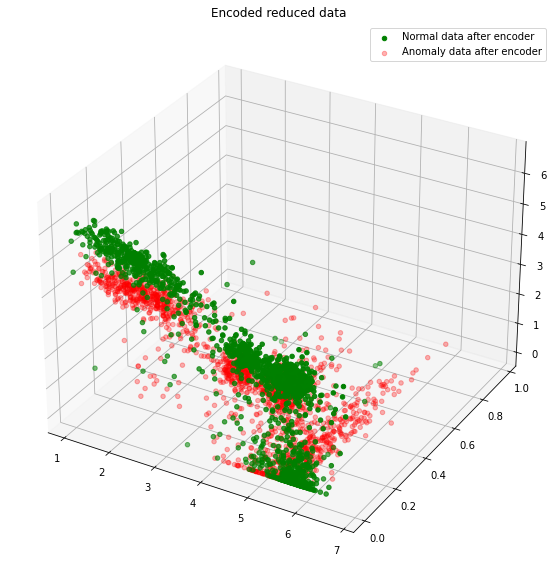

In [31]:
fig = plt.figure(figsize=(15, 10))
axs = fig.add_subplot(111, projection='3d')
# axs.scatter(encoded_normilized_data[:,0], range(len(encoded_normilized_data)), encoded_normilized_data[:,1], color="g", label="Normal data after encoder")
# axs.scatter(encoded_anomaly_normilized_data[:,0], range(len(encoded_anomaly_normilized_data)), encoded_anomaly_normilized_data[:,1], color="r", alpha=0.3, label="Anomaly data after encoder")
axs.scatter(encoded_normilized_data[:,0], encoded_normilized_data[:,1], encoded_normilized_data[:,2], color="g", label="Normal data after encoder")
axs.scatter(encoded_anomaly_normilized_data[:,0], encoded_anomaly_normilized_data[:,1], encoded_anomaly_normilized_data[:,2], color="r", alpha=0.3, label="Anomaly data after encoder")

axs.legend()
axs.set_title('Encoded reduced data')

### Only for 2 encoded components

In [32]:
def make_histogram(data):
    hist, xedges, yedges = np.histogram2d(data[:,0], 
                                          data[:,1], 
                                          bins=100, 
                                          range=[[np.min(data[:,0]), np.max(data[:,0])], 
                                                 [np.min(data[:,1]), np.max(data[:,1])]])
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()
    return xpos, ypos, zpos, dx, dy, dz


Text(0.5, 0.92, 'Encoded reduced data')

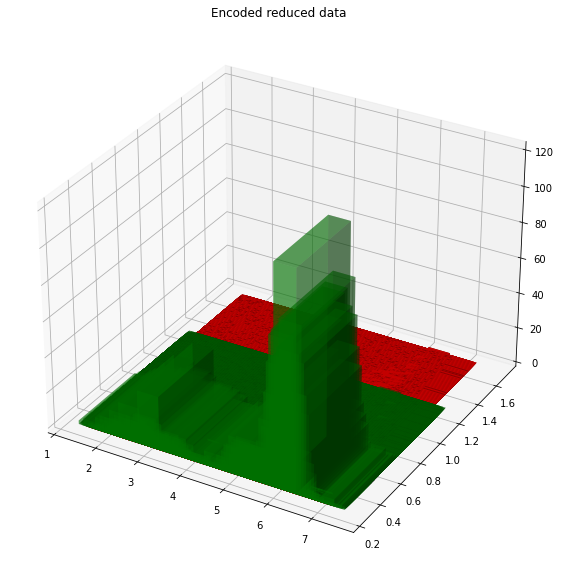

In [33]:
fig = plt.figure(figsize=(15, 10))
axs = fig.add_subplot(111, projection='3d')
xpos, ypos, zpos, dx, dy, dz = make_histogram(encoded_normilized_data);
xpos_1, ypos_1, zpos_1, dx_1, dy_1, dz_1 = make_histogram(encoded_anomaly_normilized_data);
axs.bar3d(xpos_1, ypos_1, zpos_1, dx_1, dy_1, dz_1, zsort='average', color="r", label="Encoded anomaly data")
axs.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color="g", alpha=0.4, label="Encoded normal data")
axs.set_title('Encoded reduced data')

## Model

In [15]:
import pystan

In [16]:
MILTI_DIM_GMM_MODEL = """
data {
    int<lower=1> D;            // Dimentions
    int<lower=0> N;            // Number of measurements
    vector[D] y[N];            // Data
    
    int<lower=1> k;// Number of Gaussians

}
parameters {
    vector[D] mu[k];
    vector<lower=0.0>[D] sigma[k];
    simplex[k] theta;
}
model {
    real ll[k];
    
    for (n in 1:N) {
        for (m in 1:k) {
            ll[m] <- log(theta[m]);
            for (d in 1:D) {
                ll[m] <- ll[m] + normal_log(y[n, d], mu[m, d], sigma[m, d]);
            }
        }
        target += log_sum_exp(ll);
    }       
}
"""

In [34]:
model = None
if os.path.isfile('./stan/model_multigmm.pkl'):
    model = pickle.load(open('./stan/model_multigmm.pkl', 'rb'))
else:  
    model = pystan.StanModel(model_code=MILTI_DIM_GMM_MODEL, verbose=False, extra_compile_args=["-w"])
    with open('./stan/model_multigmm.pkl', 'wb') as f:
        pickle.dump(model, f)

In [35]:
def train_multi_gmm(num_of_gaussians, data):
    print(data.shape)
    st_data= {
        'N':data.shape[0],
        'D': data.shape[1],
        'y': data,
        'k': num_of_gaussians
    }
    fit = None
    if os.path.isfile('./stan/multi_fit_' + DATASET_NAME+ '_' + str(num_of_gaussians) + '_' + str(data.shape[1]) + '.pkl'):
        fit = pickle.load(open('./stan/multi_fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '_' + str(data.shape[1]) + '.pkl', 'rb'))
    else:
        fit = model.sampling(data=st_data, iter=1000, verbose=False, n_jobs=-1)
        with open('./stan/multi_fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '_' + str(data.shape[1]) + '.pkl', 'wb') as g:
            pickle.dump(fit, g)
    
    print(fit)
    samples = fit.extract(permuted=True)
    mu = samples['mu']
    sigma = samples['sigma']
    theta = samples['theta']
    print(np.mean(mu, axis=0))
    print(np.mean(sigma, axis=0))
    print(np.mean(theta, axis=0))
    
    return mu, sigma, theta

In [36]:
mu, sigma, theta = train_multi_gmm(2, encoded_normilized_data)

(1676, 3)

Gradient evaluation took 0.002761 seconds
1000 transitions using 10 leapfrog steps per transition would take 27.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002864 seconds
1000 transitions using 10 leapfrog steps per transition would take 28.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002844 seconds
1000 transitions using 10 leapfrog steps per transition would take 28.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.003079 seconds
1000 transitions using 10 leapfrog steps per transition would take 30.79 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 22)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 22)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the 

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 


 Elapsed Time: 232.934 seconds (Warm-up)
               339.06 seconds (Sampling)
               571.994 seconds (Total)

Inference for Stan model: anon_model_08e1c9a3e21e50322d00591c61dc7733.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd    2.5%      25%    50%     75%  97.5%  n_eff   Rhat
mu[1,1]      1.27    0.69   0.97  6.1e-3     0.31   1.32    2.23   2.46      2  1.0e4
mu[2,1]      1.67    1.19   1.69    0.09     0.39   1.05    3.08   4.49      2  2.1e4
mu[1,2]     -0.45    0.32   0.45   -0.99    -0.91  -0.41 4.1e-10 5.6e-8      2 9481.7
mu[2,2]      0.03    0.03   0.05 -2.9e-8 -2.5e-11 2.2e-3    0.06   0.11      2 983.08
mu[1,3]      0.78    0.83   1.17   -0.23    -0.02   0.28    1.67   2.78      2  1.5e4
mu[2,3]      2.18    0.95   1.35    0.53     0.84   2.17    3.52   3.84      2  1.9e4
sigma[1,1]   3.25    1.31   1.86    1.43     1.46   2.92    5.11   5.74      2 4890.2
si

/Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  from ipykernel import kernelapp as app
